In [10]:
import torch
from torch import nn
import torchaudio

In [5]:
from cnn_model import CNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
model = CNN()
model.load_state_dict(torch.load('training_results/nn_classifier_statedict.pt', map_location=device))
model.eval()

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(2, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): Tanh()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (13): Tanh()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [91]:
def preprocess(filepath):
    # resampling, to mono
    wf, sr = torchaudio.load(filepath)
    resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=22050)
    wf = resample(wf)
    wf = torch.mean(wf, dim=0)

    # transform to spectrogram,
    make_spectrogram = torchaudio.transforms.Spectrogram(n_fft=510, hop_length=259, power=None, return_complex=True)
    input_spec = make_spectrogram(wf)

    # split in real and imaginary numbers
    input_tensor = torch.empty(size=list([2] + list(input_spec.shape)))
    input_tensor[0] = input_spec.real
    input_tensor[1] = input_spec.imag

    # create batch for input in neural network
    input_batch = torch.split(input_tensor, 256, dim=-1)
    if ((input_tensor.shape[-1]%256) != 0):
        input_batch = torch.stack(input_batch[:-1])
    else:
        input_batch = torch.stack(input_batch)
    
    return input_batch

In [92]:
input_batch = preprocess('witchfucker-dunkel.wav')
result = model(input_batch)
result = nn.Softmax(dim=1)(result).detach().numpy()

In [125]:
def plot_spectrogram(filepath):
    wf, sr = torchaudio.load(filepath)
    wf = torchaudio.transforms.Resample(orig_freq=sr, new_freq=22050)(wf)
    wf = torch.mean(wf, dim=0)

    spec = torchaudio.transforms.Spectrogram(n_fft=510, hop_length=259, power=None, return_complex=True)(wf)
    spec = spec.log2().real.numpy()
    plt.figure(figsize=(16, 6))
    plt.imshow(spec, origin='lower', cmap='inferno', aspect='auto', alpha=.6)
    plt.show()

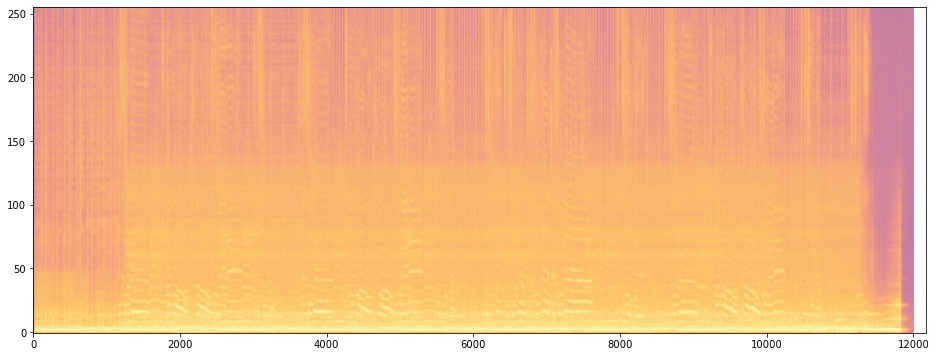

In [126]:
plot_spectrogram('witchfucker-dunkel.wav')

In [47]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np

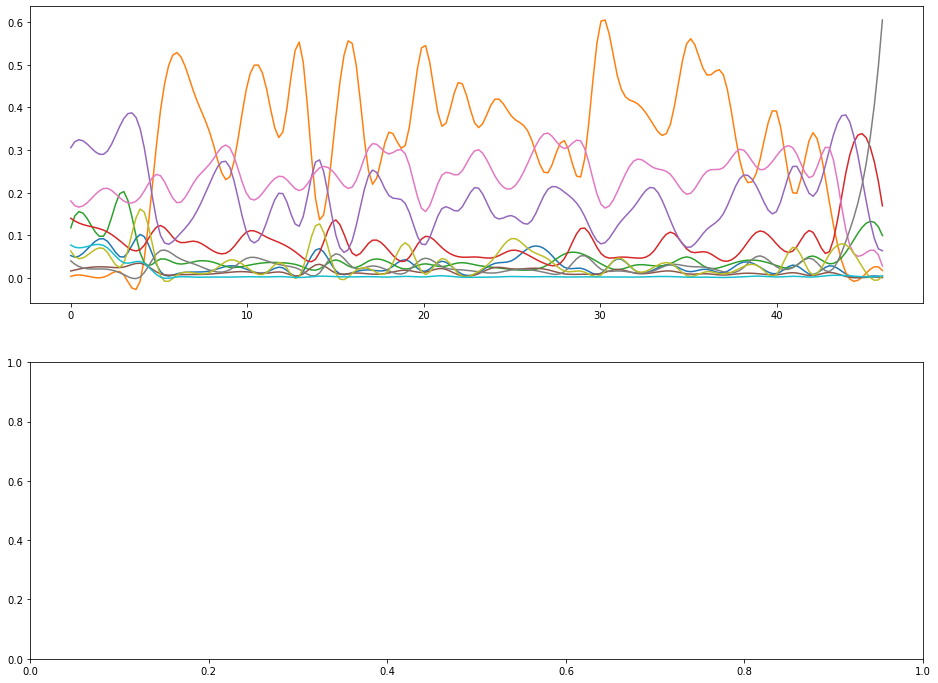

In [120]:
#create data
x = np.array(np.arange(0, 47))

fig, ax = plt.subplots(2, 1, figsize=(16, 12))

for i in np.arange(0, 10):
    y = np.array(result[:,i])
    #define x as 200 equally spaced values between the min and max of original x 
    xnew = np.linspace(x.min(), x.max(), 200) 
    #define spline
    spl = make_interp_spline(x, y, k=3)
    y_smooth = spl(xnew)
    #create smooth line chart 
    ax[0].plot(xnew, y_smooth)



plt.show()

In [134]:
len(result)


47

In [210]:
input_genre = []
for i in np.arange(len(result)):
    input_genre.append(np.where(result[i]==result[i].max())[0][0])

In [211]:
x = np.linspace(0, 47*3, 48)

In [212]:
y = [list(x[a:a+2]) for a in np.arange(len(x)-1)]

In [213]:
import pandas as pd
x = pd.Series(input_genre)

In [214]:
x.replace({0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red', 4: 'tab:purple', 5: 'tab:brown', 6: 'tab:pink', 7: 'tab:gray', 8: 'tab:olive', 9: 'tab:cyan'}, inplace=True)
x = x.tolist()

In [215]:
z = list(zip(y, x))

In [216]:
z[0][0][0], z[0][0][1], z[0][1]

(0.0, 3.0, 'tab:purple')

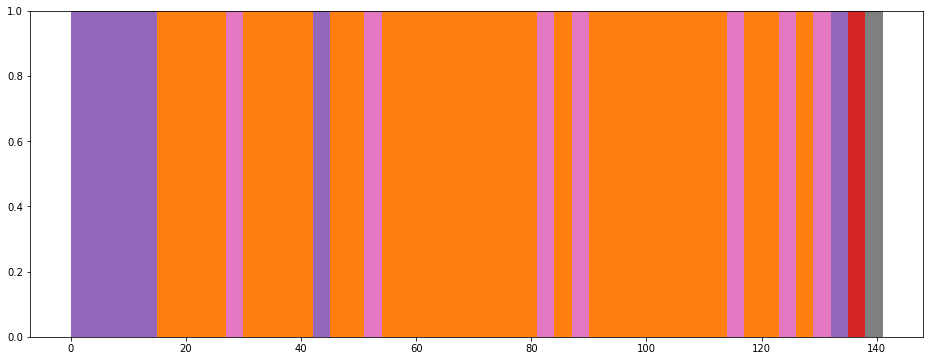

In [219]:
plt.figure(figsize=(16, 6))

for i in np.arange(47):
    plt.axvspan(xmin=z[i][0][0], xmax=z[i][0][1], color=z[i][1])
plt.show()